# Create SparkSession, import packages

### To update git hub
### git pull
### git add *
### git commit -m "Insert you change message"
### git push origin master

# To Do:
* combine the data with the features file, to get a header
* do variable selection and transformation
* spit out a final `.csv` to use for modeling

# Ideas
* look at the data via kmeans with 6 clusters?
* compute AUC on each variable to see which are important? (after regressing on the var)
* create variables that are combinations of other variables
* look for outliers and then run pca before clustering?
* run multinomial regression with elastic net? (with k-fold cv)
* or maybe try neural nets?
* something time series?


In [110]:
from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
import os
import pandas as pd
import numpy as np
from pyspark.mllib.linalg import Vectors, SparseVector
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.mllib.linalg.distributed import RowMatrix
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
import scipy.sparse
from pyspark.ml.linalg import Vectors, _convert_to_vector, VectorUDT

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("xor") \
    .config("spark.executor.memory", '4g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'4g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

# Read in Data

In [2]:
#read in with pandas first since the data is weirdly delimited
#train features
pandas_train_features = pd.read_csv("Data/X_train.txt", sep='\s+',header=None)
#conversion to spark df
df_train_features = sqlCtx.createDataFrame(pandas_train_features)

In [3]:
#training labels
pandas_train_labels = pd.read_csv("Data/y_train.txt", sep='\s+',header=None)
pandas_train_labels.columns=['position']
#conversion to spark df
df_train_labels = sqlCtx.createDataFrame(pandas_train_labels)

In [4]:
#test features
pandas_test_features = pd.read_csv("Data/X_test.txt", sep='\s+',header=None)
#conversion to spark df
df_test_features = sqlCtx.createDataFrame(pandas_test_features)

In [5]:
#test labels
pandas_test_labels = pd.read_csv("Data/y_test.txt", sep='\s+',header=None)
pandas_test_labels.columns=['position']
#conversion to spark df
df_test_labels = sqlCtx.createDataFrame(pandas_test_labels)

In [6]:
#header
pandas_header = pd.read_csv("Data/features.txt", sep='\s+',header=None)
#conversion to spark df. this has an index column, so we deselect it
df_header = sqlCtx.createDataFrame(pandas_header)


In [7]:
#pull out the header names. "id" is an identifier, and "position" is the label
df_header_names = ["id"] + df_header.select('1').rdd.map(lambda row : row[0]).collect() + ["position"]

In [8]:
#reading subject number in
panda_sub_train=pd.read_csv("Data/subject_train.txt",sep='\s+',header=None)
panda_sub_train.columns=['id']

panda_sub_test=pd.read_csv("Data/subject_test.txt",sep='\s+',header=None)
panda_sub_test.columns=['id']
df_sub_train=sqlCtx.createDataFrame(panda_sub_train)
df_sub_test=sqlCtx.createDataFrame(panda_sub_test)

# Merge header, id, features, and label, and split into training/test set

In [9]:
#merge x feature files with subject id
merged_train=pd.merge(panda_sub_train,pandas_train_features, right_index=True, left_index=True)
merged_test=pd.merge(panda_sub_test,pandas_test_features, right_index=True, left_index=True)

#transform to df
df_merged_train_features=sqlCtx.createDataFrame(merged_train)
df_merged_test_features=sqlCtx.createDataFrame(merged_test)

In [10]:
#merge train files with subject id, testing and training sets
#Dennis
#pd.concat([df_a, df_b], axis=1) example
mergetrain=pd.concat([merged_train,pandas_train_labels],axis=1)
mergetest=pd.concat([merged_test,pandas_test_labels],axis=1)

#combine train and test to resplit into 80-20
combine=pd.concat([mergetrain,mergetest],axis=0)

In [11]:
#convert into SparkDF
df_complete_merge=sqlCtx.createDataFrame(combine)

#resplit data to 80:20
(train_data, test_data)=df_complete_merge.randomSplit(seed=314,weights=[0.8,0.2])

In [12]:
#add headers
#note: train_data is what we're using as our "primary" dataset
train_data = train_data.toDF(*df_header_names)

test_data = test_data.toDF(*df_header_names)


In [13]:
##remove bandEnergy columns because they are not unique. They represent the "intensity" of activity in the frequency domain.

# first, we pull out the columns that have bandsEnergy in them
train_band_cols = [s for s in train_data.columns if 'bandsEnergy' in s]
test_band_cols = [s for s in test_data.columns if 'bandsEnergy' in s]

# then, we pull out these columns out of the data
train_data = train_data.select([a for a in train_data.columns if a not in train_band_cols])
test_data = test_data.select([a for a in test_data.columns if a not in test_band_cols])


In [14]:
#split into features (x) and labels (y)
    #note that the label is the "position" column
train_x = train_data.drop("position")
train_y = train_data.select("position") 

test_x = test_data.drop("position")
test_y = test_data.select("position")

In [15]:
train_x.show(5)

+---+-----------------+--------------------+-----------------+----------------+--------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+--------------------+----------------+----------------+--------------+-------------------+--------------------+-------------------+----------------+----------------+----------------+--------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+--------------------------+--------------------------+--------------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------

# Data exploration (looking for NA, summary stats, counts, )

In [16]:
#check for missing values
from pyspark.sql.functions import isnan, when, count, col
train_x.select([count(when(isnan(c), c)).alias(c) for c in train_x.columns]).show()

#we note that there are no missing values


+---+-----------------+-----------------+-----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+--------------+-------------------+-------------------+-------------------+----------------+----------------+----------------+--------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+--------------------------+--------------------------+--------------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------

In [17]:
#getting an idea of what the data looks like by computing a summary
train_x.select(train_x.columns[1:5]).describe().show()

+-------+-------------------+--------------------+--------------------+-------------------+
|summary|  tBodyAcc-mean()-X|   tBodyAcc-mean()-Y|   tBodyAcc-mean()-Z|   tBodyAcc-std()-X|
+-------+-------------------+--------------------+--------------------+-------------------+
|  count|               8214|                8214|                8214|               8214|
|   mean| 0.2741672598077674|-0.01782892635303...|-0.10915220003803862|-0.6073341095553922|
| stddev|0.06700302726138603| 0.03591625355986128| 0.05274787651955511|  0.437108344479308|
|    min|               -1.0|         -0.68409659|         -0.92598834|               -1.0|
|    max|                1.0|                 1.0|                 1.0|                1.0|
+-------+-------------------+--------------------+--------------------+-------------------+



In [18]:
#look at the data by seeing how many rows there are
ds = pd.DataFrame(index=[1], columns=['train_features_obs','train_labels_obs','test_features_obs','test_labels_obs', 'header_obs'])
ds['train_features_obs'] = df_train_features.count()
ds['train_labels_obs'] = df_train_labels.count()
ds['test_features_obs'] = df_test_features.count()
ds['test_labels_obs'] = df_test_labels.count()
ds['header_obs']= df_header.count()
ds=sqlCtx.createDataFrame(ds)
ds.show()                #created data frame to show how many obs in each file
                        #makes it easier to see under df, -Kevin

    
    
    
    
#can we do this, but in pyspark instead? - nathan


+------------------+----------------+-----------------+---------------+----------+
|train_features_obs|train_labels_obs|test_features_obs|test_labels_obs|header_obs|
+------------------+----------------+-----------------+---------------+----------+
|              7352|            7352|             2947|           2947|       561|
+------------------+----------------+-----------------+---------------+----------+



# Scale the Data

In [19]:
# Vectorize the data for modeling
#exclude 1st column (id) and last column (position)
assembler = VectorAssembler(inputCols = train_data.columns[1:-1], outputCol = "features")
train_vectorized = assembler.transform(train_data)
train_vectorized = train_vectorized.select("id","features", "position")

test_vectorized = assembler.transform(test_data)
text_vectorized = test_vectorized.select("id", "features", "position")

In [20]:
# scale the features
    # we don't scale mean, since our data is not all on the same scale
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False)

scalerModel_train = scaler.fit(train_vectorized)

#change train_x_vectorized to also be scaled
train_vectorized = scalerModel_train.transform(train_vectorized).drop('features')\
                     .withColumnRenamed('scaledFeatures', 'features')

# Trying PCA

In [21]:
# PCA For scree plot
pca_10 = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
pca_train_10 = pca_10.fit(train_vectorized)

#compute the pve
train_pve_10 = pca_train_10.explainedVariance.cumsum()

#map data to the space mapped by the first 5 pc
train_10 = pca_train_10.transform(train_vectorized).select("pcaFeatures", "position")

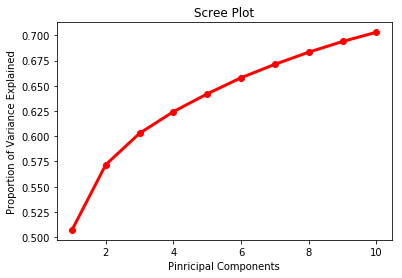

In [22]:
# Scree Plot

number_of_pc = np.arange(1,11)
plt.plot(number_of_pc, train_pve_10, 'ro-', linewidth = 3)
plt.title('Scree Plot')
plt.xlabel("Pinricipal Components")
plt.ylabel("Proportion of Variance Explained")
plt.show()



In [23]:
# PCA for plotting and cluster analysis
pca_2 = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_train_2 = pca_2.fit(train_vectorized)

#compute the pve
train_pve_2 = pca_train_2.explainedVariance.cumsum()

#map data to the space mapped by the first 5 pc
train_2 = pca_train_2.transform(train_vectorized).select("pcaFeatures")

In [24]:
train_pc1 = train_2.rdd.map(lambda x: (x[0][0])).collect()
train_pc2 = train_2.rdd.map(lambda x: (x[0][1])).collect()

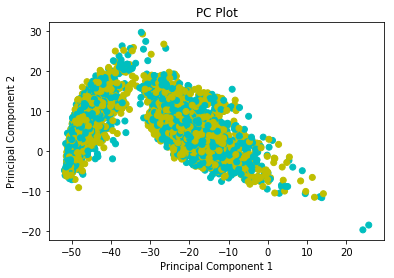

In [25]:
#plot the first pc on x axis, second pc on y axix
plt.scatter(train_pc1,train_pc2,c='yc')
plt.title('PC Plot')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [26]:
#create kmeans.
kmeans = KMeans().setK(6).setSeed(1)

In [27]:
#kmeans needs a column named features, so we rename them
train_2 = train_2.withColumnRenamed('pcaFeatures', 'features')
train_2kmeans = kmeans.fit(train_2.select('features'))

In [28]:
#apply the model to the data and extract the data
train_2_cluster_w_pred = train_2kmeans.transform(train_2)
train_2cluster_label = train_2_cluster_w_pred.select('prediction').rdd.map(lambda x: x[0]).collect()

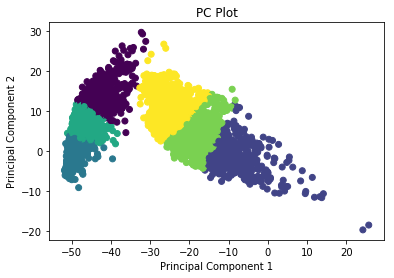

In [29]:
#plot the pc data based on the cluster assignments
plt.scatter(train_pc1,train_pc2,c=train_2cluster_label)
plt.title('PC Plot')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [30]:
wssse = train_2kmeans.computeCost(train_2.select('features'))
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 123444.53210303844


# Random Forest ( on 10 pc)

In [82]:
#quick function to convert a dense vector to sparse one

def dense_to_sparse(vector):
    return _convert_to_vector(scipy.sparse.csc_matrix(vector.toArray()).T)

In [102]:
def parsePoint(line):
    values = [float(x) for x in line.replace(',', ' ').split(' ')]
    return LabeledPoint(values[0], values[1:])

In [103]:
#trying to turn the our data frame into a labledPoint form for use in modeling
#this doesnt work yet because we need features to be a sparsevector

#train_10.rdd.map(lambda row: LabeledPoint(features = row[0], label = row[1])).take(5)
#df.rdd.map(lambda row: LabeledPoint(row[-1], Vectors.dense(row[0:-1])))
test=train_10.rdd.map(lambda x: LabeledPoint(x[1],x[0])) #This is the 80 split and works for labeled point creation
train_data2=train_data.rdd.map(lambda x: LabeledPoint(x[-1],x[1:-2]))

In [113]:
#this doesn't work yet because we need to get train_10 into labeledPoint format
#rfmodel = RandomForest.trainClassifier(train, numClasses=7, categoricalFeaturesInfo={},
                                     numTrees=1000, featureSubsetStrategy="auto",maxDepth=4, maxBins=32)


Py4JJavaError: An error occurred while calling o5096.trainRandomForestModel.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 177.0 failed 1 times, most recent failure: Lost task 0.0 in stage 177.0 (TID 476, localhost, executor driver): java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.ml.tree.impl.DTStatsAggregator.<init>(DTStatsAggregator.scala:77)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$14.apply(RandomForest.scala:545)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$14.apply(RandomForest.scala:541)
	at scala.Array$.tabulate(Array.scala:331)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:541)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:538)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:743)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:742)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:742)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:567)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:201)
	at org.apache.spark.mllib.tree.RandomForest.run(RandomForest.scala:94)
	at org.apache.spark.mllib.tree.RandomForest$.trainClassifier(RandomForest.scala:129)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainRandomForestModel(PythonMLLibAPI.scala:781)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.ml.tree.impl.DTStatsAggregator.<init>(DTStatsAggregator.scala:77)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$14.apply(RandomForest.scala:545)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$14.apply(RandomForest.scala:541)
	at scala.Array$.tabulate(Array.scala:331)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:541)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:538)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 41688)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pysp

In [ ]:
to_sparse = udf(dense_to_sparse, VectorUDT())
#DF.withColumn("sparse", to_sparse(col("densevector"))

# Question 2: Which action "category" has the most predictive power?
(ie time-based Body acceleration, frequency-based Body acceleration, Gyro, angle, ect)

In [ ]:
#splits the header column on dashes, and creates a data frame with each of the elements

split_col = F.split(df_header['1'], '-')
df_header = df_header.withColumn('Main', split_col.getItem(0))
df_header = df_header.withColumn('Seconded', split_col.getItem(1)) #Kevin

In [ ]:
df_header.show()

In [ ]:
#count the number of unique elements in the "main" column of the header df
header_summary=df_header.groupBy('Main').count()
header_summary.count()                               #Kevin
              

In [ ]:
#show the unique elements in "main" by count (show all 24 of them)
    # we note that there are "bins" we can look at, which we specify in final_group_names below
    # also, our code was unable to parse the "angle" columns directly, so we will do those separately
header_summary_ordered = header_summary.orderBy('count',ascending = False)      #Kevin
header_summary_ordered.show(24)

In [ ]:
#create vector with the "group names" as entries
    #first 17 are all the non-angle names. we only want these, since we are treating angles separately
    
header_split_names = header_summary_ordered.select('Main').rdd.map(lambda row : row[0]).collect()[1:17]
final_group_names = ["fBodyAcc", "tBodyGyro", "tBodyAcc", "fBodyBody", "tGravityAcc"]

In [ ]:
#since our regex above doesn't deal with the angle format, we treat them separately
    #so we want to pull them out of our dataset so we can deal with everything else

angle_cols = [s for s in train_x.columns if 'angle' in s]
train_x_without_angles = train_x.select([a for a in train_x.columns if a not in angle_cols])

In [ ]:
# creates a list, where each element is a data frame in one of the group names in final_group_names, plus an element for "angle" columns

df_list = []
for name in final_group_names:
    selected = [s for s in train_x_without_angles.columns if name in s]
    df_list.append(train_x_without_angles.select(selected))
    
    
# we ignored angles until now, so we append the angle dataframe separately
#train_x.select("column").where("column like '%fBodyGyro%'")
angle_cols = [s for s in train_x_without_angles.columns if 'angle' in s]

#add 
df_list.append(train_x_without_angles.select(angle_cols))

In [ ]:
df_list[0]

In [ ]:
header_summary.groupBy("Main").count().rdd.values().histogram(20)   #Kevin

In [ ]:
import matplotlib.pyplot

header_barplot= df_header.toPandas()                    # converted to pandas since easier, RDD tricky
header_barplot['Main'].value_counts().plot(kind='bar')  #Visualize Main Variable count
                                                        #Kevin

# Look for class imbalance

In [ ]:
#count the number of activites done
y_train_summary=train_y.groupBy('position').count()      
y_train_summary.count()     # total activities                                                  #kevin

In [ ]:
#look for class imbalance in how much each activity was done.
y_train_summary.show()

In [ ]:
y_train_summary_dist = y_train_summary.orderBy('count', ascending = False)
y_train_summary_dist.show()

In [ ]:
# add a column for proportion
sum_counts = train_y.count()
y_train_summary_dist.withColumn('Frequency (%)', F.round(y_train_summary_dist[1]/sum_counts * 100, 2)).show()


In [ ]:
y_train_barplot= train_y.toPandas()                    # converted to pandas since easier, RDD tricky
y_train_barplot['position'].value_counts().plot(kind='bar')      #maybe nicer if we change x axis to display activity label?

In [ ]:
y_test_summary=df_test_labels.groupBy('position').count()       #0 is column name
y_test_summary.count()     # total activities 

In [ ]:
import matplotlib.pyplot
y_train_bar=y_train_barplot['position'].value_counts() #data read
increment=[1,2,3,4,5,6]
names=['laying','standing','sitting','walking','walking\ndownstairs','walking\nupstairs']
matplotlib.pyplot.bar(increment, y_train_bar, align='center', alpha=0.5, color='c') #Barplot
matplotlib.pyplot.xticks(increment,names)
matplotlib.pyplot.ylabel('Counts')
matplotlib.pyplot.xlabel('Positions')
matplotlib.pyplot.title('Acitivity position distribution')
matplotlib.pyplot.show()

#how are the positiosn distributed?

In [ ]:
y_test_summary.show()

In [ ]:
y_test_summary.orderBy('count', ascending=False).show()      #ordered from biggest to smallest
                                                            # kevin

In [ ]:
y_test_barplot= df_test_labels.toPandas()                    # converted to pandas since easier, RDD tricky
y_test_barplot['position'].value_counts().plot(kind='bar')     #Kevin
Y_test_bar=y_test_barplot['position'].value_counts()

In [ ]:
increment=[1,2,3,4,5,6]
names=['laying','standing','sitting','walking','walking\ndownstairs','walking\nupstairs']
matplotlib.pyplot.bar(increment, Y_test_bar, align='center', alpha=0.5, color='c') #Barplot
matplotlib.pyplot.xticks(increment,names)
matplotlib.pyplot.ylabel('Counts')
matplotlib.pyplot.xlabel('Positions')
matplotlib.pyplot.title('Acitivity position distribution')
matplotlib.pyplot.show()

In [ ]:
id_labels=df_complete_merge.select('id','position')
walkdown=id_labels.filter(id_labels['position']==5).groupBy('id').count().orderBy('id', ascending=True).drop('id').toPandas() #only walking
walkup=id_labels.filter(id_labels['position']==6).groupBy('id').count().orderBy('id',ascending=True).drop('id').toPandas()
#the two datasets are sorted by ascending order ex: 0-30
#the two datasets are counted already, by id
#the two datasets contains only walking up or walking down

In [ ]:
#I need help plotting the two into side by side to do comparison


# Outlier Detection, Using Interquartile Range Method

In [ ]:
cols = [c for c in train_x.columns]   # exclude id from features
bounds = {} # will store lower and upper bounds for each feature              #Will use later, -Kevin

In [ ]:
#this takes a while to run
for col in cols:
    quantiles = train_x.approxQuantile(col, [0.25, 0.75], 0.05)    #creating desired quantiles in data,
    IQR = quantiles[1] - quantiles[0]

    bounds[col] = [
     quantiles[0] - 1.5 * IQR,
     quantiles[1] + 1.5 * IQR
    ]

In [ ]:
bounds     #bounds for IQR, lower bound at .25 and upper bound at .75

In [ ]:
# append outlier indicators to data table
#code from preprocessing tutorial, added ".cast("int"), 0 is false aka no outlier, 1 indicates outlier

outliers = train_x.select(*['id'] + [
 (
 (train_x[c] < bounds[c][0]) | (train_x[c] > bounds[c][1]))
    .cast("int").alias(c + '_outlier') for c in cols
])

In [ ]:
#sums takes the sum of each column in the outliers df, since 1 indicates outlier
sums = [F.sum(x).alias(str(x)) for x in outliers.columns]
df_totaloutliers = outliers.select(sums).collect()[0] #assocites each column name to its sum
df_totaloutliers

In [ ]:
outliers.groupBy('id').count().show()     # of obs per subject, since is time series data, measurements taken at time interval

In [ ]:
#rough draft, trying to list dict object above to sort by highest outlier value, having tough time sorting 
#sums takes the sum of each column in the outliers df, since 1 indicates outlier
sums2 = [F.sum(x).alias(str(x)) for x in outliers.columns]
df_totaloutliers2 = outliers.select(sums).collect()[0].asDict()
df_totaloutliers2

In [ ]:
#graphs of outliers using seaborn, columns are random, will replace with highest
#rough draft for now
import numpy as np; np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = train_x.toPandas()
dff = pd.DataFrame(data = np.random.random(size=(4,4)), columns = ['tBodyAcc-mean()-Z','tBodyAcc-mean()-X',' tGravityAcc-min()-Z','BodyAcc-std()-X'])

sns.boxplot(x="variable", y="value", data=pd.melt(dff))
plt.show()

#df

import seaborn as sns
sns.set(style="whitegrid")
tips = df['tBodyAcc-mean()-Z','tBodyAcc-mean()-X',' tGravityAcc-min()-Z','BodyAcc-std()-X']
ax = sns.boxplot(x=df['tBodyAcc-mean()-Z','tBodyAcc-mean()-X',' tGravityAcc-min()-Z','BodyAcc-std()-X'])

ax = sns.boxplot(x="day", y="total_bill", data=tips)
ax = sns.swarmplot(x="day", y="total_bill", data=tips, color=".25")

In [ ]:
df.describe()

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
tips = df["BodyAcc-std()-X"]
#ax = sns.boxplot(x=df['tBodyAcc-mean()-Z','tBodyAcc-mean()-X',' tGravityAcc-min()-Z','BodyAcc-std()-X'])

ax = sns.boxplot(data=tips)
ax = sns.swarmplot(data=tips, color=".25")